# Segmenting and Clustering Neighbourhoods in Toronto

All three Questions andwers are in this same full notebook.
Look in to corresponding section for the related answer.

##  Question 1 :

This notebook was created with Python 3.8.2, Jupyter Lab and TensorFlow GPU kernel.

### First import required libraries

In [1]:
#import all the libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline
print('Packages installed  :)')

Packages installed  :)


#### Get the page from Wikipedia

The page given in excersice has new layout and nested tab/cr split table.

Using the old page with simple table in it. 

In [2]:
# Get the file using beautiful soup 
#url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
url="https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&direction=prev&oldid=926287641"

result = requests.get(url)
data_html = BeautifulSoup(result.content)

In [3]:
soup = BeautifulSoup(str(data_html))
neigh = soup.find('table')
table_str = str(neigh.extract())
df = pd.read_html(table_str)[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Drop all the rows which have Boroughs 'Not assigned' and then reset the index. Assumed looking at the wikipedia link that the Neighborhoods with the same Postal Code appear on the same row so further cleansing didnt have to be done to satisfy requirements

In [4]:
df_dropna = df[df.Borough != 'Not assigned'].reset_index(drop=True)
df_dropna.rename(columns={'Postcode' : 'PostalCode'}, inplace=True)
print(df_dropna.shape) # Check to see the shape of the dataframe, comment out when funtional

(211, 3)


### Making Neighborhood "Not assigned", same as Borough name:

In [5]:
for index, row in df_dropna.iterrows():
    if row["Neighbourhood"] == "Not assigned":
        row["Neighbourhood"] = row["Borough"]
        
df_dropna.head()

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


Preprocess data so that Broroughs are grouped based on their name

In [6]:
df = df_dropna
df.head()

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [7]:
df_grouped = df.groupby(['Borough', 'PostalCode'], as_index=False).agg(lambda x:','.join(x))
df_grouped.head(20)

,Borough,PostalCode,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,North Toronto West
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park,Summerhill East"
5,Central Toronto,M4V,"Deer Park,Forest Hill SE,Rathnelly,South Hill,..."
6,Central Toronto,M5N,Roselawn
7,Central Toronto,M5P,"Forest Hill North,Forest Hill West"
8,Central Toronto,M5R,"The Annex,North Midtown,Yorkville"
9,Downtown Toronto,M4W,Rosedale


In [8]:
df_grouped.loc[df_grouped['Borough'].isin(["Not assigned"])] #check ih empty


,Borough,PostalCode,Neighbourhood


So now all the requirements are met and the data is cleansed, now we just have to add the Latitude and Longitudes of each location

In [9]:
df_grouped.reset_index(drop=True)

,Borough,PostalCode,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,North Toronto West
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park,Summerhill East"
...,...,...,...
98,York,M6C,Humewood-Cedarvale
99,York,M6E,Caledonia-Fairbanks
100,York,M6M,"Del Ray,Keelesdale,Mount Dennis,Silverthorn"
101,York,M6N,"The Junction North,Runnymede"


In [10]:
list(df_grouped.columns.values)

['Borough', 'PostalCode', 'Neighbourhood']

Rearranged the Columns so the PostalCode appears first

In [11]:
df_grouped = df_grouped[['PostalCode', 'Borough', 'Neighbourhood']]
list(df_grouped.columns.values)

['PostalCode', 'Borough', 'Neighbourhood']

In [12]:
df_grouped.head()

,PostalCode,Borough,Neighbourhood
0,M4N,Central Toronto,Lawrence Park
1,M4P,Central Toronto,Davisville North
2,M4R,Central Toronto,North Toronto West
3,M4S,Central Toronto,Davisville
4,M4T,Central Toronto,"Moore Park,Summerhill East"


In [13]:
df_grouped.shape

(103, 3)

## Question 2 :

Now we are going to create a new table with the Latitudes and Longitudes corresponding to the different PostalCodes

In [14]:
#geo_url = "https://cocl.us/Geospatial_data"
geo_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Next We Will merge the data. We will make the actual data equal to the temporary data frame we are working with becauase we are happy with it and then we will merge it based on the postal code.

In [15]:
df = df_grouped
df = pd.merge(df, geo_df, on='PostalCode')
df.head()


,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160


## Question 3 :

### Map of Toronto

Creating map of Toronto using latitude and longitude values and adding markers to it.

In [16]:
# create map of Toronto using latitude and longitude values
latitude = 43.653225
longitude = -79.383186
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.75,
        parse_html=False).add_to(map_toronto)  
    
map_toronto


### Next we will define foursquare Credentials

In [24]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20200514'
LIMIT = 100 # limit of number of venues returned by Foursquare API
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VIHECMBTSH4ODEFH0RIRIAYH3BSUFEDYVA12GYARKYEG331N
CLIENT_SECRET:VBMBP4TNVAWCV5XO55YC23QOUTD5LLGTQBLR4ZGXD2WRPZDK


In [25]:
df.loc[0, 'Neighbourhood']

'Lawrence Park'

We will analyze the first Neighborhood, Lawrence Park

In [26]:
law_lat = df.loc[0, 'Latitude']
law_long = df.loc[0, 'Longitude']
law_name = df.loc[0, 'Neighbourhood']

print('Latitude and longitude values of {} are {}, {}.'.format(law_name, law_lat, law_long))

Latitude and longitude values of Lawrence Park are 43.7280205, -79.3887901.


Now, let's get the top 100 venues that are in Lawrence Park within a radius of 500 meters.

First, let's create the GET request URL. Name your URL url.


In [27]:
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    law_lat, 
    law_long, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=VIHECMBTSH4ODEFH0RIRIAYH3BSUFEDYVA12GYARKYEG331N&client_secret=VBMBP4TNVAWCV5XO55YC23QOUTD5LLGTQBLR4ZGXD2WRPZDK&v=20200514&ll=43.7280205,-79.3887901&radius=500&limit=100'

In [28]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '608e6f2818545271202dd9f8'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 3,
  'suggestedBounds': {'ne': {'lat': 43.7325205045, 'lng': -79.3825744605273},
   'sw': {'lat': 43.7235204955, 'lng': -79.3950057394727}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '50e6da19e4b0d8a78a0e9794',
       'name': 'Lawrence Park Ravine',
       'location': {'address': '3055 Yonge Street',
        'crossStreet': 'Lawrence Avenue East',
        'lat': 43.72696303913755,
        'lng': -79.39438246708775,
        'labeledL

Firs define function that extracts the category of the venue

In [29]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Next we will clean the json and structure it into a pandas dataframe

In [30]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()


,name,categories,lat,lng
0,Lawrence Park Ravine,Park,43.726963,-79.394382
1,Zodiac Swim School,Swim School,43.728532,-79.382860
2,TTC Bus #162 - Lawrence-Donway,Bus Line,43.728026,-79.382805


Let's look how many venues around Lawrence Avenue were found

In [31]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

3 venues were returned by Foursquare.


That was just one Neighborhood in Toronto.
For all venues we will use a forloop to run through all the neighborhoods in Toronto repeating above process.

In [32]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



Now we will run the above function on each neighborhood and create a new dataframe called toronto_venues

In [33]:
toronto_venues = getNearbyVenues(names=df['Neighbourhood'], latitudes=df['Latitude'], longitudes=df['Longitude']
)


Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park,Summerhill East
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
Roselawn
Forest Hill North,Forest Hill West
The Annex,North Midtown,Yorkville
Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront,Regent Park
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie
The Beaches
The Danforth West,Riverdale
The Beaches West,India Bazaar
Studio District
Business Reply Mail Processing Centre 969 Eastern
Woodbine Gardens,Parkview Hill
Woodbine Heights
Leaside
Thorncliffe Park
East Toronto
Humber 

In [34]:
print('Venues table shape: ',toronto_venues.shape)
print(' ')
print(toronto_venues.head())

Venues table shape:  (2132, 7)
 
       Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Lawrence Park              43.728020              -79.388790   
1     Lawrence Park              43.728020              -79.388790   
2     Lawrence Park              43.728020              -79.388790   
3  Davisville North              43.712751              -79.390197   
4  Davisville North              43.712751              -79.390197   

                            Venue  Venue Latitude  Venue Longitude  \
0            Lawrence Park Ravine       43.726963       -79.394382   
1              Zodiac Swim School       43.728532       -79.382860   
2  TTC Bus #162 - Lawrence-Donway       43.728026       -79.382805   
3         Summerhill Market North       43.715499       -79.392881   
4                   Sherwood Park       43.716551       -79.387776   

      Venue Category  
0               Park  
1        Swim School  
2           Bus Line  
3  Food & Drink Shop  
4         

list how many venues were returned for each neighborhood

In [35]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide,King,Richmond",95,95,95,95,95,95
Agincourt,4,4,4,4,4,4
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",3,3,3,3,3,3
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",9,9,9,9,9,9
"Alderwood,Long Branch",6,6,6,6,6,6
...,...,...,...,...,...,...
Willowdale West,5,5,5,5,5,5
Woburn,4,4,4,4,4,4
"Woodbine Gardens,Parkview Hill",11,11,11,11,11,11


Check how many unique Venue categories

In [36]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 271 uniques categories.


## Next analyze each neighborhood

In [37]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print('Shape of dataframe', toronto_onehot.shape)
print(' ')
print(toronto_onehot.head())


Shape of dataframe (2132, 271)
 
   Yoga Studio  Accessories Store  Adult Boutique  Airport  \
0            0                  0               0        0   
1            0                  0               0        0   
2            0                  0               0        0   
3            0                  0               0        0   
4            0                  0               0        0   

   Airport Food Court  Airport Lounge  Airport Service  Airport Terminal  \
0                   0               0                0                 0   
1                   0               0                0                 0   
2                   0               0                0                 0   
3                   0               0                0                 0   
4                   0               0                0                 0   

   American Restaurant  Antique Shop  ...  Truck Stop  \
0                    0             0  ...           0   
1                    0 

In [38]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide,King,Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021053,...,0.0,0.010526,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Alderwood,Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
94,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
95,"Woodbine Gardens,Parkview Hill",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
96,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0


Print each neighborhood with the five most common venues

In [39]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,King,Richmond----
             venue  freq
0      Coffee Shop  0.11
1             Café  0.05
2       Restaurant  0.04
3  Thai Restaurant  0.04
4    Deli / Bodega  0.03


----Agincourt----
                       venue  freq
0                     Lounge  0.25
1  Latin American Restaurant  0.25
2             Breakfast Spot  0.25
3             Clothing Store  0.25
4  Middle Eastern Restaurant  0.00


----Agincourt North,L'Amoreaux East,Milliken,Steeles East----
                 venue  freq
0         Intersection  0.33
1           Playground  0.33
2                 Park  0.33
3   Mexican Restaurant  0.00
4  Monument / Landmark  0.00


----Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown----
            venue  freq
0     Pizza Place  0.22
1   Grocery Store  0.22
2  Sandwich Place  0.11
3        Pharmacy  0.11
4      Beer Store  0.11


----Alderwood,Long Branch----
            venue  freq
0     Pizza Place  0.33
1             

                 venue  freq
0                 Café  0.16
1                  Bar  0.06
2  Japanese Restaurant  0.06
3            Bookstore  0.06
4               Bakery  0.06


----Harbourfront East,Toronto Islands,Union Station----
                 venue  freq
0          Coffee Shop  0.13
1             Aquarium  0.05
2                Hotel  0.04
3                 Café  0.04
4  Fried Chicken Joint  0.03


----Harbourfront,Regent Park----
         venue  freq
0  Coffee Shop  0.16
1         Park  0.07
2          Pub  0.07
3       Bakery  0.07
4         Café  0.07


----High Park,The Junction South----
                 venue  freq
0   Mexican Restaurant  0.08
1      Thai Restaurant  0.08
2                 Café  0.08
3       Discount Store  0.04
4  Arts & Crafts Store  0.04


----Highland Creek,Rouge Hill,Port Union----
                             venue  freq
0                              Bar   1.0
1                      Yoga Studio   0.0
2        Middle Eastern Restaurant   0.0
3        

                venue  freq
0         Pizza Place  0.18
1            Pharmacy  0.09
2  Athletics & Sports  0.09
3         Flea Market  0.09
4                Café  0.09


----Woodbine Heights----
                venue  freq
0        Intersection  0.11
1         Video Store  0.11
2            Bus Stop  0.11
3  Athletics & Sports  0.11
4        Dance Studio  0.11


----York Mills West----
                        venue  freq
0                        Park  0.33
1  Construction & Landscaping  0.33
2           Convenience Store  0.33
3                 Yoga Studio  0.00
4          Mexican Restaurant  0.00




Let's put that into a pandas dataframe

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


Next list the top 10 venues for each of the neighborhood

In [41]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(11)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Restaurant,Thai Restaurant,Deli / Bodega,Clothing Store,Gym,Seafood Restaurant,Salad Place,Concert Hall
1,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Clothing Store,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Intersection,Playground,Park,Mexican Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Pizza Place,Grocery Store,Sandwich Place,Pharmacy,Beer Store,Fried Chicken Joint,Fast Food Restaurant,Organic Grocery,Optical Shop,Pet Store
4,"Alderwood,Long Branch",Pizza Place,Pub,Sandwich Place,Gym,Coffee Shop,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop
5,"Bathurst Manor,Downsview North,Wilson Heights",Coffee Shop,Bank,Park,Shopping Mall,Middle Eastern Restaurant,Mobile Phone Shop,Sandwich Place,Supermarket,Fried Chicken Joint,Sushi Restaurant
6,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Yoga Studio,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop
7,"Bedford Park,Lawrence Manor East",Italian Restaurant,Sandwich Place,Restaurant,Coffee Shop,Indian Restaurant,Fast Food Restaurant,Liquor Store,Butcher,Café,Sushi Restaurant
8,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Farmers Market,Seafood Restaurant,Beer Bar,Pharmacy,Restaurant,Concert Hall
9,"Birch Cliff,Cliffside West",College Stadium,Skating Rink,General Entertainment,Café,Farm,Massage Studio,Medical Center,Mediterranean Restaurant,Martial Arts School,Men's Store


Cluster these Neighbourhoods

In [42]:
from sklearn.cluster import KMeans
kclusters = 5 # set number of clusters

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood. Let's first try the Elbow method to find the optimum K value.


In [43]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = toronto_grouped.drop(['Neighborhood'], axis=1)

kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [44]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [45]:
scores = [get_inertia(x) for x in range(2, 21)]


Text(0, 0.5, 'Error')

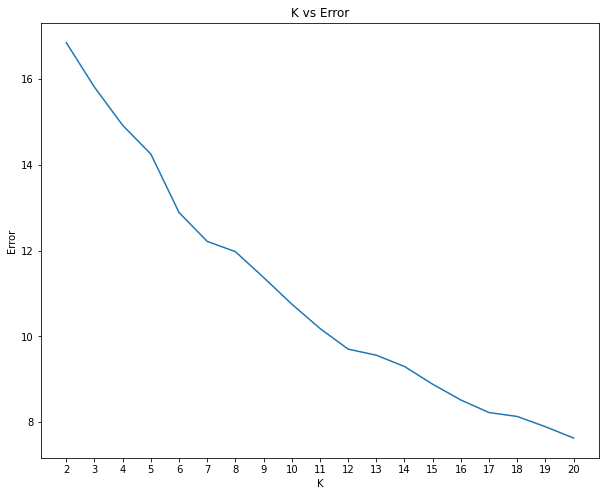

In [46]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores)
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

We can see from above that the point that sharply turns and reduces the speed of the error is ad k=5 (in this dataset)

In [47]:
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [48]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

toronto_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1.0,Park,Bus Line,Swim School,Yoga Studio,Mexican Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Men's Store
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197,0.0,Pizza Place,Breakfast Spot,Department Store,Food & Drink Shop,Park,Hotel,Gym,Gym / Fitness Center,Sandwich Place,Medical Center
2,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,0.0,Coffee Shop,Clothing Store,Sporting Goods Shop,Yoga Studio,Italian Restaurant,Park,Restaurant,Chinese Restaurant,Diner,Salon / Barbershop
3,M4S,Central Toronto,Davisville,43.704324,-79.388790,0.0,Dessert Shop,Sandwich Place,Café,Sushi Restaurant,Pizza Place,Coffee Shop,Gym,Italian Restaurant,Indian Restaurant,Restaurant
4,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160,2.0,Restaurant,Yoga Studio,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Men's Store,Moroccan Restaurant


In [49]:
toronto_merged.tail()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
98,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,1.0,Field,Park,Hockey Arena,Trail,Yoga Studio,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop
99,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,1.0,Park,Women's Store,Pool,Men's Store,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant
100,M6M,York,"Del Ray,Keelesdale,Mount Dennis,Silverthorn",43.691116,-79.476013,0.0,Fast Food Restaurant,Restaurant,Discount Store,Fried Chicken Joint,Sandwich Place,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Monument / Landmark
101,M6N,York,"The Junction North,Runnymede",43.673185,-79.487262,0.0,Caribbean Restaurant,Breakfast Spot,Grocery Store,Brewery,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop
102,M9N,York,Weston,43.706876,-79.518188,1.0,Jewelry Store,Convenience Store,Yoga Studio,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Men's Store


Drop invalid values in Clusters or Venues

In [50]:
#toronto_drop = toronto_merged[toronto_merged.Cluster_Labels != 'NaN'].reset_index(drop=True)
toronto_merged.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)


### Visualize

Here we see where are most of the venues located. This gives us indication where most of the people are going around and therefore best places for hospitality and retail businesses.

In [51]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.75).add_to(map_clusters)
       
map_clusters


## Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can assign a name to each cluster.


### Cluster 1

In [52]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Central Toronto,0.0,Pizza Place,Breakfast Spot,Department Store,Food & Drink Shop,Park,Hotel,Gym,Gym / Fitness Center,Sandwich Place,Medical Center
2,Central Toronto,0.0,Coffee Shop,Clothing Store,Sporting Goods Shop,Yoga Studio,Italian Restaurant,Park,Restaurant,Chinese Restaurant,Diner,Salon / Barbershop
3,Central Toronto,0.0,Dessert Shop,Sandwich Place,Café,Sushi Restaurant,Pizza Place,Coffee Shop,Gym,Italian Restaurant,Indian Restaurant,Restaurant
5,Central Toronto,0.0,Coffee Shop,Light Rail Station,Bagel Shop,Pub,Restaurant,Liquor Store,Supermarket,Sushi Restaurant,Fried Chicken Joint,Bank
6,Central Toronto,0.0,Health & Beauty Service,Garden,Music Venue,Yoga Studio,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Mexican Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
95,West Toronto,0.0,Mexican Restaurant,Thai Restaurant,Café,Discount Store,Arts & Crafts Store,Gastropub,Bar,Fried Chicken Joint,Bakery,Music Venue
96,West Toronto,0.0,Breakfast Spot,Gift Shop,Coffee Shop,Bank,Dog Run,Eastern European Restaurant,Italian Restaurant,Restaurant,Movie Theater,Dessert Shop
97,West Toronto,0.0,Coffee Shop,Café,Pub,Pizza Place,Italian Restaurant,Sushi Restaurant,Yoga Studio,Falafel Restaurant,Fish & Chips Shop,Restaurant
100,York,0.0,Fast Food Restaurant,Restaurant,Discount Store,Fried Chicken Joint,Sandwich Place,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Monument / Landmark


### Cluster 2 

In [53]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]



,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Toronto,1.0,Park,Bus Line,Swim School,Yoga Studio,Mexican Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Men's Store
7,Central Toronto,1.0,Jewelry Store,Park,Trail,Sushi Restaurant,Yoga Studio,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Men's Store
9,Downtown Toronto,1.0,Park,Playground,Trail,Yoga Studio,Men's Store,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant
33,East York,1.0,Intersection,Video Store,Bus Stop,Athletics & Sports,Dance Studio,Skating Rink,Beer Store,Curling Ice,Park,Mexican Restaurant
36,East York,1.0,Park,Convenience Store,Intersection,Yoga Studio,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop
46,Etobicoke,1.0,Park,Mobile Phone Shop,Sandwich Place,Yoga Studio,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Mediterranean Restaurant
56,North York,1.0,Park,Construction & Landscaping,Convenience Store,Yoga Studio,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant
58,North York,1.0,Food & Drink Shop,Park,Yoga Studio,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Men's Store,Mediterranean Restaurant
63,North York,1.0,Airport,Bus Stop,Park,Yoga Studio,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant
64,North York,1.0,Grocery Store,Bank,Park,Shopping Mall,Yoga Studio,Mexican Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant


## Cluster 3

In [54]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,2.0,Restaurant,Yoga Studio,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Men's Store,Moroccan Restaurant


## Cluster 4

In [55]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,Etobicoke,3.0,Park,Baseball Field,Yoga Studio,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Men's Store
65,North York,3.0,Food Truck,Business Service,Baseball Field,Korean Restaurant,Yoga Studio,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant
73,North York,3.0,Baseball Field,Yoga Studio,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Mexican Restaurant,Lounge


## Cluster 5

In [56]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


## Conclusion :

Venues that are in Lawrence Park within a radius of 500 meters most are in Clusters 1 and 2. There are only one boroughs in Clusters 5 and 6.

We can select other centerpoints and distance parameters to examine other interesting locations. This can be used for example to get information what happens around particular hotel location and submitted to customers on daily bases or used by travel agent for hotel recommendations.
